### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,b_piece_activity,w_doubled_pawns,b_doubled_pawns,doubled_pawns_diff,w_isolated_pawns,b_isolated_pawns,isolated_pawns_diff,both_castled_early,total_captures_early,activity_diff
0,2404,2534,0,0,130,2469.0,0,-130,0,20.0,...,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.0,1.0
1,2752,2395,2,0,357,2573.5,1,357,0,16.0,...,27.0,0.0,0.0,0.0,3.0,1.0,2.0,0,18.0,0.0
2,2558,2685,2,0,127,2621.5,0,-127,1,22.0,...,32.0,0.0,0.0,0.0,0.0,1.0,-1.0,0,14.0,-2.0
3,2514,2351,0,0,163,2432.5,1,163,0,6.0,...,23.0,0.0,0.0,0.0,0.0,1.0,-1.0,0,20.0,-2.0
4,2582,2494,2,0,88,2538.0,1,88,0,18.0,...,41.0,1.0,0.0,1.0,4.0,0.0,4.0,0,17.0,-6.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1686173, 54)
Target: (1686173,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 18.47 seconds (0.31 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.6364 (63.64%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.62      0.71      0.66    132965
        Draw       0.73      0.32      0.45     64732
   White Win       0.64      0.71      0.67    139538

    accuracy                           0.64    337235
   macro avg       0.66      0.58      0.59    337235
weighted avg       0.65      0.64      0.62    337235



### 6. Confusion Matrix

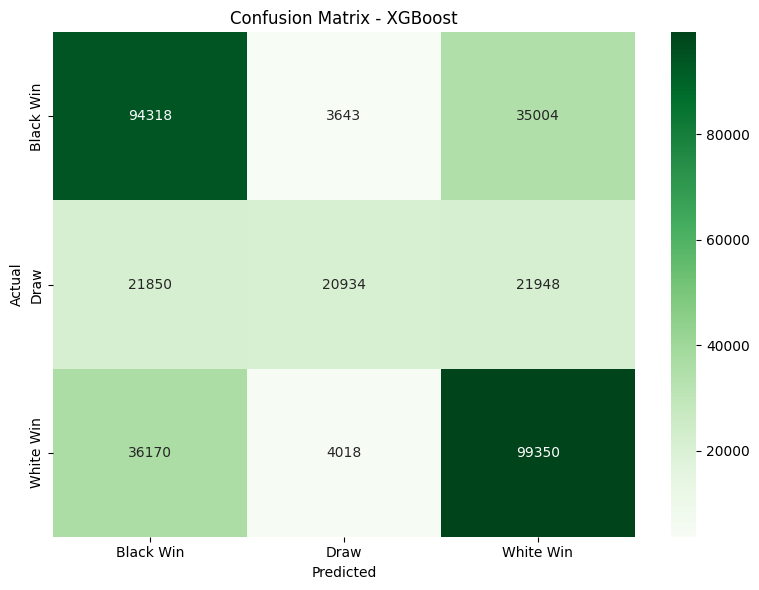

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
4               AvgRating    0.201578
10    material_diff_early    0.188249
6    WhiteRatingAdvantage    0.063360
0                WhiteElo    0.048422
1                BlackElo    0.040392
3              RatingDiff    0.028776
52   total_captures_early    0.026414
27       b_captures_early    0.026326
9        b_material_early    0.022354
2             EventTypeID    0.020911
53          activity_diff    0.020358
20                w_rooks    0.018681
36          b_development    0.017542
30     b_aggression_early    0.017455
8        w_material_early    0.015503
28     capture_diff_early    0.014689
21                b_rooks    0.014569
44       b_piece_activity    0.013728
26       w_captures_early    0.011967
35          w_development    0.011633
19            bishop_diff    0.011116
31  aggression_diff_early    0.010191
22              rook_diff    0.009361
43       w_piece_activity    0.008781
15              b_knights    0.008752
14          

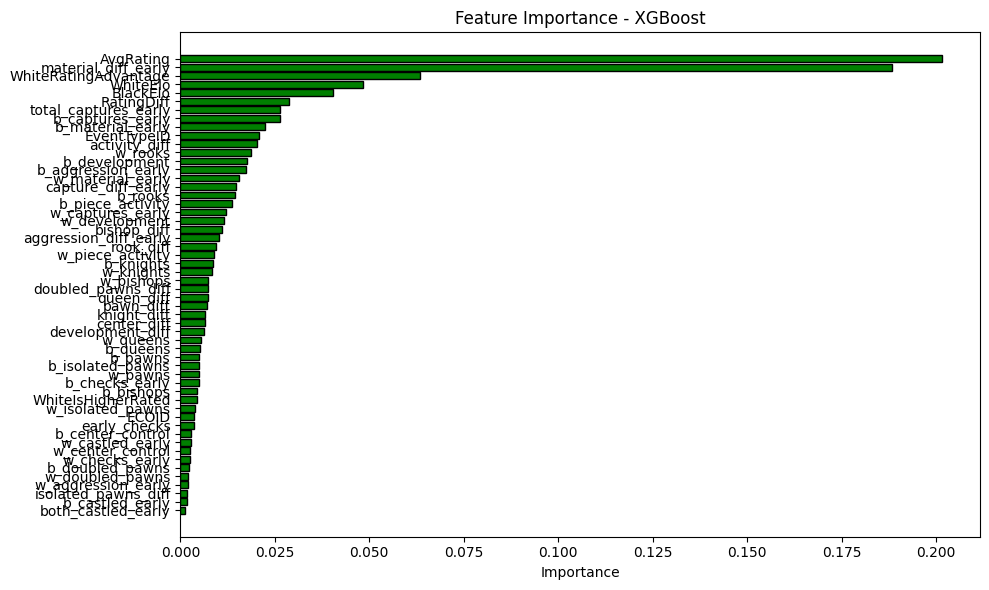

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()